In [1]:
import os
# import numpy as np # to process the data
import random
import math
import sys
import matplotlib.pyplot as plt
# !pip install h5py
import h5py
from random import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# !gdown "1-c3WBSePwzFh9i2b9rZLGOk6MjXy0r4F"
# !unzip data_shoe_sandal_boot.zip

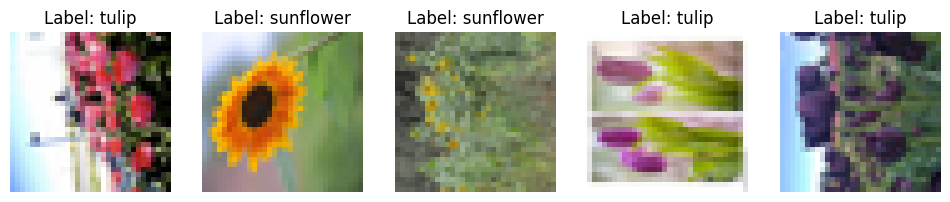

Unique labels:  {'sunflower', 'rose', 'daisy', 'tulip', 'dandelion'}
Total number of images: 300
Dimensions of each image: (32, 32, 3)
Total dimensions of the dataset (assuming all images have the same shape): 300 x (32, 32, 3)
Train set size: 225, Validation set size: 45, Test set size: 30
Unique classes in the training set: [0, 1, 2, 3, 4]
Number of classes for prediction: 5


In [3]:
class FlowerDataset:
    def __init__(self, directory, image_size=(32, 32)):
        self.directory = directory
        self.image_size = image_size
        self.images = []
        self.labels = []
        self.original_labels = []

    def load_data(self):
        image_files = os.listdir(self.directory)
        # for img in image_files:
        for img in image_files[:300]:
            try:
                img_path = os.path.join(self.directory, img)
                with Image.open(img_path) as img_array:
                    # Convert image to RGB
                    img_array = img_array.convert("RGB").resize(self.image_size)
                    img_data = [[list(img_array.getpixel((x, y))) for y in range(self.image_size[1])] for x in range(self.image_size[0])]
                    self.images.append(img_data)
                    label = img.split('_')[0]
                    self.labels.append(label)
                    self.original_labels.append(label)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    def preprocess_data(self):
        max_pixel_value = 255.0
        self.images = [[[[value / max_pixel_value for value in pixel] for pixel in row] for row in image] for image in self.images]

    def display_images(self, num_images=5):
        if not self.images:
            print("No images to display. Please load the data first.")
            return

        plt.figure(figsize=(12, 3))  # Adjust the size as needed
        for i in range(min(num_images, len(self.images))):
            plt.subplot(1, num_images, i+1)
            # Convert the pixel values back to the 0-255 range and display the image
            img_data = self.images[i]
            img_data = [[[int(pixel_value * 255) for pixel_value in pixel] for pixel in row] for row in img_data]
            img = Image.new('RGB', (len(img_data[0]), len(img_data)))
            pixels = img.load()
            for x in range(img.width):
                for y in range(img.height):
                    pixels[x, y] = tuple(img_data[y][x])
            plt.imshow(img)
            plt.title(f"Label: {self.original_labels[i]}")
            plt.axis('off')  # Hide the axis
        plt.show()

    def print_dataset_dimensions(self):
        if self.images:
            print(f"Total number of images: {len(self.images)}")
            print(f"Dimensions of each image: ({len(self.images[0])}, {len(self.images[0][0])}, {len(self.images[0][0][0])})")
            print(f"Total dimensions of the dataset (assuming all images have the same shape): {len(self.images)} x ({len(self.images[0])}, {len(self.images[0][0])}, {len(self.images[0][0][0])})")
        else:
            print("The dataset is empty or not loaded properly.")

    def one_hot_encode(self):
        unique_labels = sorted(set(self.labels))
        self.label_to_int = {label: index for index, label in enumerate(unique_labels)}
        self.int_to_label = {index: label for index, label in enumerate(unique_labels)}  # New line
        self.label_indices = [self.label_to_int[label] for label in self.labels]
        self.labels = [[int(i == label_index) for i in range(len(unique_labels))] for label_index in self.label_indices]

def split_data(images, labels, train_ratio, validation_ratio, test_ratio):
    combined = list(zip(images, labels))
    shuffle(combined)
    shuffled_images, shuffled_labels = zip(*combined)

    train_end = int(len(shuffled_images) * train_ratio)
    validation_end = train_end + int(len(shuffled_images) * validation_ratio)

    x_train = shuffled_images[:train_end]
    y_train = shuffled_labels[:train_end]
    x_val = shuffled_images[train_end:validation_end]
    y_val = shuffled_labels[train_end:validation_end]
    x_test = shuffled_images[validation_end:]
    y_test = shuffled_labels[validation_end:]

    return list(x_train), list(x_val), list(x_test), list(y_train), list(y_val), list(y_test)

# Usage
dataset = FlowerDataset('flower2')
dataset.load_data()
dataset.preprocess_data()
dataset.display_images(num_images=5)
dataset.one_hot_encode()

x_train, x_val, x_test, y_train, y_val, y_test = split_data(dataset.images, dataset.labels, 0.75, 0.15, 0.10)

original_labels = set(dataset.original_labels)
print("Unique labels: ", original_labels)

# print("y_train after one hot encoded: ", y_train)

# Print the dimensions of the preprocessed images
dataset.print_dataset_dimensions()

# Print the sizes of the datasets
print(f"Train set size: {len(x_train)}, Validation set size: {len(x_val)}, Test set size: {len(x_test)}")

# Print the unique classes in the training set
unique_classes = sorted(set([label.index(1) for label in y_train]))
print(f"Unique classes in the training set: {unique_classes}")

num_classes = len(unique_classes)
print(f"Number of classes for prediction: {num_classes}")


In [4]:
class Limiting:
    @staticmethod
    def clip(values, min_value, max_value):
        # Check if values is a list or a single value
        if isinstance(values, list):
            return [max(min(value, max_value), min_value) for value in values]
        else:
            return max(min(values, max_value), min_value)

    @staticmethod
    def get_unique_filename(base_filename, extension):
        # Start with 0 suffix and increment until a unique filename is found
        counter = 0
        unique_filename = f"{base_filename}_{counter}.{extension}"
        while os.path.exists(unique_filename):
            counter += 1
            unique_filename = f"{base_filename}_{counter}.{extension}"
        return unique_filename

    @staticmethod
    def min_max_scale(data):
        min_val = min(data)
        max_val = max(data)
        range_val = max_val - min_val
        if range_val == 0:
            return [0 for _ in data]  # Return a list of zeros if all values are the same
        scaled_data = [(value - min_val) / range_val for value in data]
        return scaled_data

    @staticmethod
    def convert_to_one_hot(predicted):
        one_hot_predicted = []
        for pred in predicted:
            # Find the index with the maximum probability
            max_index = pred.index(max(pred))
            # Create a one-hot encoded vector
            one_hot_vector = [0] * len(pred)
            one_hot_vector[max_index] = 1
            one_hot_predicted.append(one_hot_vector)
        return one_hot_predicted

In [5]:
# Base Layer class
class Layer:
    def forward(self, input_data):
        raise NotImplementedError

    def backward(self, output_error, learning_rate):
        raise NotImplementedError

# Convolutional Layer
class ConvLayer(Layer):
    def __init__(self, num_filters, filter_size, num_channels=3, padding=0, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = [[[[random.random() for _ in range(num_channels)] for _ in range(filter_size)] for _ in range(filter_size)] for _ in range(num_filters)]
        self.padding = padding
        self.stride = stride
        
    def forward(self, input_data):
        # # Assert that the input data has the expected shape
        # assert len(input_data.shape) == 4, f"Expected input shape to be 4D, got {input_data.shape}"
        # # Ensure the input data has four dimensions: batch size, height, width, and depth
        # if len(input_data.shape) < 4:
        #     input_data = np.expand_dims(input_data, axis=0)  # Add a batch dimension
        self.last_input = input_data
        batch_size, h, w, d = len(input_data), len(input_data[0]), len(input_data[0][0]), len(input_data[0][0][0])
    
        new_h = (h + 2 * self.padding - self.filter_size) // self.stride + 1
        new_w = (w + 2 * self.padding - self.filter_size) // self.stride + 1
        output = [[[[0 for _ in range(self.num_filters)] for _ in range(new_w)] for _ in range(new_h)] for _ in range(batch_size)]
    
        for b in range(batch_size):
            for i in range(0, new_h, self.stride):
                for j in range(0, new_w, self.stride):
                    for f in range(self.num_filters):
                        h_start = i*self.stride
                        h_end = h_start+self.filter_size
                        w_start = j*self.stride
                        w_end = w_start+self.filter_size
    
                        patch = [[[input_data[b][x][y][c] for c in range(d)] for y in range(w_start, w_end)] for x in range(h_start, h_end)]
                        output_value = sum(sum(sum(a*b for a, b in zip(patch_row, filter_row)) for patch_row, filter_row in zip(patch_channel, filter_channel)) for patch_channel, filter_channel in zip(patch, self.filters[f]))
                        # output[b][i][j][f] = Limiting.clip(output_value, 1e - 9, 1 - (1e -9))  # Clip the output value using Limiting.clip
                        output[b][i][j][f] = output_value
    
        return output

    def backward(self, output_error, learning_rate):
        self.last_input = self.last_input
        batch_size, h, w, d = len(self.last_input), len(self.last_input[0]), len(self.last_input[0][0]), len(self.last_input[0][0][0])
    
        new_h = (h + 2 * self.padding - self.filter_size) // self.stride + 1
        new_w = (w + 2 * self.padding - self.filter_size) // self.stride + 1
        output = [[[[0 for _ in range(self.num_filters)] for _ in range(new_w)] for _ in range(new_h)] for _ in range(batch_size)]
    
        for b in range(batch_size):
            for i in range(0, new_h, self.stride):
                for j in range(0, new_w, self.stride):
                    for f in range(self.num_filters):
                        h_start = i*self.stride
                        h_end = h_start+self.filter_size
                        w_start = j*self.stride
                        w_end = w_start+self.filter_size
    
                        patch = [[self.last_input[b][x][y] for y in range(w_start, w_end)] for x in range(h_start, h_end)]
                        output_value = sum(sum(sum(a*b for a, b in zip(patch_row, filter_row)) for patch_row, filter_row in zip(patch_channel, filter_channel)) for patch_channel, filter_channel in zip(patch, self.filters[f]))
                        output[b][i][j][f] = Limiting.clip(output_value, -10**9, 10**9)  # Clip the output value using Limiting.clip
    
        return output
        
# ReLU Activation
class ReLULayer(Layer):
    def forward(self, input_data):
        self.last_input = input_data
        return self.apply_relu(input_data)

    def backward(self, output_error, learning_rate):
        return self.apply_relu_gradient(output_error)

    def apply_relu(self, data):
        # Apply ReLU to each value in the input data
        return [[[[max(0, val) for val in channel] for channel in depth] for depth in width] for width in data]

    def apply_relu_gradient(self, error):
        # Apply the gradient of ReLU to the output error
        return [[[[err * (val > 0) for err, val in zip(channel_err, channel_val)]
                  for channel_err, channel_val in zip(depth_err, depth_val)]
                 for depth_err, depth_val in zip(width_err, width_val)]
                for width_err, width_val in zip(error, self.last_input)]

# MaxPooling Layer
class MaxPoolingLayer(Layer):
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, input_data):
        self.last_input = input_data
        batch_size, h, w, num_filters = len(input_data), len(input_data[0]), len(input_data[0][0]), len(input_data[0][0][0])
        output = [[[[0 for _ in range(num_filters)] for _ in range(w // self.pool_size)] for _ in range(h // self.pool_size)] for _ in range(batch_size)]
        for b in range(batch_size):
            for i in range(h // self.pool_size):
                for j in range(w // self.pool_size):
                    for f in range(num_filters):
                        patch = [[input_data[b][x][y][f] for y in range(j*self.pool_size, (j+1)*self.pool_size)] for x in range(i*self.pool_size, (i+1)*self.pool_size)]
                        max_value = max(max(row) for row in patch)
                        # output[b][i][j][f] = Limiting.clip(max_value, 1e - 9 , 1 - (1e - 9))  # Clip the output value using Limiting.clip
                        output[b][i][j][f] = max_value
        return output

    def backward(self, output_error, learning_rate):
        # Initialize d_input with zeros, having the same shape as the last input
        d_input = [[[[
            0 for _ in range(len(self.last_input[0][0][0]))] 
            for _ in range(len(self.last_input[0][0]))] 
            for _ in range(len(self.last_input[0]))] 
            for _ in range(len(self.last_input))]

        for b in range(len(self.last_input)):
            for h in range(0, len(self.last_input[b]), self.pool_size):
                for w in range(0, len(self.last_input[b][h]), self.pool_size):
                    for c in range(len(self.last_input[b][h][w])):
                        # Find the max value in the pooling window
                        max_value = None
                        max_h = 0
                        max_w = 0
                        for i in range(self.pool_size):
                            for j in range(self.pool_size):
                                current_h = h + i
                                current_w = w + j
                                if current_h < len(self.last_input[b]) and current_w < len(self.last_input[b][current_h]):
                                    if max_value is None or self.last_input[b][current_h][current_w][c] > max_value:
                                        max_value = self.last_input[b][current_h][current_w][c]
                                        max_h = current_h
                                        max_w = current_w
                        # Propagate the error to the max location
                        if h//self.pool_size < len(output_error[b]) and w//self.pool_size < len(output_error[b][h//self.pool_size]):
                            d_input[b][max_h][max_w][c] = output_error[b][h//self.pool_size][w//self.pool_size][c]

        return d_input
        
class FlattenLayer(Layer):
    def forward(self, input_data):
        self.last_input_shape = [len(input_data), len(input_data[0]), len(input_data[0][0]), len(input_data[0][0][0])]
        flattened = []
        
        for b in range(self.last_input_shape[0]):
            for i in range(self.last_input_shape[1]):
                for j in range(self.last_input_shape[2]):
                    for k in range(self.last_input_shape[3]):
                        value = input_data[b][i][j][k]
                        # clipped_value = Limiting.clip(value, -10**6, 10**6)  # Clip the value using Limiting.clip
                        # flattened.append(clipped_value)
                        flattened.append(value)
                        
        return [flattened]  # Return a list of lists
        
    def backward(self, output_error, learning_rate):
        reshaped_error = []
        
        for b in range(self.last_input_shape[0]):
            image_error = []
            
            for i in range(self.last_input_shape[1]):
                row_error = []
                
                for j in range(self.last_input_shape[2]):
                    pixel_error = []
                    
                    for k in range(self.last_input_shape[3]):
                        error_value = output_error[0][b*self.last_input_shape[1]*self.last_input_shape[2]*self.last_input_shape[3] + i*self.last_input_shape[2]*self.last_input_shape[3] + j*self.last_input_shape[3] + k]
                        pixel_error.append(error_value)
                        
                    row_error.append(pixel_error)
                image_error.append(row_error)
            reshaped_error.append(image_error)
            
        return reshaped_error
        
# Dropout Layer
class DropoutLayer(Layer):
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, input_data):
        self.mask = self.create_dropout_mask(input_data)
        return self.apply_dropout_mask(input_data)

    def backward(self, output_error, learning_rate):
        return self.apply_dropout_mask(output_error)

    def create_dropout_mask(self, input_data):
        mask = []
        for i in range(len(input_data)):
            mask_row = self.create_mask_row(len(input_data[0]))
            mask.append(mask_row)
        return mask

    def create_mask_row(self, length):
        return [(random.random() > self.dropout_rate) / (1.0 - self.dropout_rate) for _ in range(length)]

    def apply_dropout_mask(self, input_data):
        output = []
        for i in range(len(input_data)):
            output_row = self.apply_mask_row(i, input_data[i])
            output.append(output_row)
        return output

    def apply_mask_row(self, i, input_row):
        return [self.mask[i][j] * input_row[j] for j in range(len(input_row))]

# Dense Layer
class DenseLayer(Layer):
    def __init__(self, name, input_size, output_size):
        self.name = name
        self.weights = [[random.random() for _ in range(output_size)] for _ in range(input_size)]
        self.biases = [0 for _ in range(output_size)]  # Ensure biases is a 1D array with length 'output_size'
        
    def forward(self, input_data):
        # Assert that the input data is 2D after flattening
        # assert len(input_data.shape) == 2, f"Expected input shape to be 2D, got {input_data.shape}"
        self.last_input = input_data
        output = []
        for data in input_data:
            output_row = []
            for w, b in zip(self.weights, self.biases):
                value = 0
                for d, w_ in zip(data, w):
                    value += d * w_
                value += b
                output_row.append(value)
            output.append(output_row)
        return output
    
    def backward(self, output_error, learning_rate):
        d_weights = []
        for j in range(len(self.weights)):
            d_weights_row = []
            for k in range(len(self.weights[0])):
                d_weight = 0
                for i in range(len(self.last_input)):
                    d_weight += self.last_input[i][j] * output_error[i][k]
                d_weights_row.append(d_weight)
            d_weights.append(d_weights_row)
    
        d_biases = []
        for j in range(len(self.biases)):
            d_bias = 0
            for i in range(len(output_error)):
                d_bias += output_error[i][j]
            d_biases.append(d_bias)
    
        for j in range(len(self.weights)):
            for k in range(len(self.weights[0])):
                self.weights[j][k] -= learning_rate * d_weights[j][k]
    
        for j in range(len(self.biases)):
            self.biases[j] -= learning_rate * d_biases[j]
    
        d_input = []
        for i in range(len(output_error)):
            d_input_row = []
            for j in range(len(self.weights)):
                d_input_value = 0
                for k in range(len(self.weights[0])):
                    d_input_value += self.weights[j][k] * output_error[i][k]
                d_input_row.append(d_input_value)
            d_input.append(d_input_row)
    
        return d_input
        
class SoftmaxLayer(Layer):
    def forward(self, input_data):
        # # Reshape input_data to 2D if it's 1D
        # if input_data.ndim == 1:
        #     input_data = input_data.reshape(1, -1)

        self.last_input = input_data
        output = []
        for data in input_data:
            max_value = max(data)
            exp_values = [math.exp(value - max_value) for value in data]  # Subtract max_value for numerical stability
            sum_exp_values = sum(exp_values)
            softmax_values = [exp_value / sum_exp_values for exp_value in exp_values]
            output.append(softmax_values)
        return output

    def backward(self, output_error, learning_rate):
        return output_error  # Error is passed straight through to the next layer

# Cross-Entropy Loss
class CrossEntropyLoss:
    def calculate_loss(self, predicted, actual):
        # print(predicted)
        # print(actual)
        total_loss = 0
        for pred, act in zip(predicted, actual):
            clipped_pred = [Limiting.clip(p, 1e-9, 1 - 1e-9) for p in pred]  # Clip the predicted values
            loss = -sum(act_i * math.log(pred_i) for act_i, pred_i in zip(act, clipped_pred))
            # loss = -sum(act_i * math.log(pred_i) for act_i, pred_i in zip(act, pred))
            total_loss += loss
        return total_loss
        
    def calculate_gradient(self, predicted, actual):
        # print(predicted)
        # print(actual)
        gradients = []
        for pred, act in zip(predicted, actual):
            gradient = [p - a for p, a in zip(pred, act)]
            gradients.append(gradient)
        return gradients

In [6]:
class Precision:
    def calculate(self, predicted, actual):
        class_precisions = []
        for class_id in range(self.num_classes):
            tp = sum(p == a == class_id for p, a in zip(predicted, actual))
            fp = sum(p == class_id and a != class_id for p, a in zip(predicted, actual))
            class_precision = tp / (tp + fp) if tp + fp > 0 else 0
            class_precisions.append(class_precision)
        return class_precisions

class Recall:
    def calculate(self, predicted, actual):
        class_recalls = []
        for class_id in range(self.num_classes):
            tp = sum(p == a == class_id for p, a in zip(predicted, actual))
            fn = sum(p != class_id and a == class_id for p, a in zip(predicted, actual))
            class_recall = tp / (tp + fn) if tp + fn > 0 else 0
            class_recalls.append(class_recall)
        return class_recalls

class F1Score:
    def calculate(self, predicted, actual):
        class_f1_scores = []
        precisions = Precision().calculate(predicted, actual)
        recalls = Recall().calculate(predicted, actual)
        for precision, recall in zip(precisions, recalls):
            f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
            class_f1_scores.append(f1_score)
        return class_f1_scores

In [19]:
class CNN:
    def __init__(self, num_classes, epochs=10, learning_rate=0.001, threshold=0.5, early_stopping_patience=5):
        self.layers = [
            ConvLayer(num_filters=32, filter_size=3, num_channels=3),  # num_channels is 3 for RGB images
            ReLULayer(),
            MaxPoolingLayer(pool_size=2),
            # ConvLayer(num_filters=64, filter_size=3, num_channels=32),  # num_channels is num_filters of previous ConvLayer
            # ReLULayer(),
            # MaxPoolingLayer(pool_size=2),
            # ConvLayer(num_filters=128, filter_size=3, num_channels=64),  # num_channels is num_filters of previous ConvLayer
            # ReLULayer(),
            # MaxPoolingLayer(pool_size=2),
            # ConvLayer(num_filters=256, filter_size=3, num_channels=128),  # num_channels is num_filters of previous ConvLayer
            # ReLULayer(),
            # MaxPoolingLayer(pool_size=2),
            # ConvLayer(num_filters=512, filter_size=3, num_channels=256),  # num_channels is num_filters of previous ConvLayer
            # ReLULayer(),
            # MaxPoolingLayer(pool_size=2),
            FlattenLayer(),
            # None, # -6   # Placeholder for first DenseLayer, will initialize properly later
            # ReLULayer(),
            # DropoutLayer(dropout_rate=0.1),
            # None, # -3   # Placeholder for second DenseLayer, will initialize properly later
            # ReLULayer(),
            DropoutLayer(dropout_rate=0.1),
            None, # -1   # Placeholder for third DenseLayer, will initialize properly later
            SoftmaxLayer()
        ] 
        self.loss = CrossEntropyLoss()
        self.num_classes = num_classes
        self.class_to_int = {c: i for i, c in enumerate(unique_classes)}
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0

    def forward(self, X):
        for layer in self.layers:
            if layer is not None:
                # Ensure X is a NumPy array
                # if isinstance(X, list):
                #     X = np.array(X)
                # print(f"+ Before forward - {type(layer).__name__}: {self.get_shape(X)}")
                X = layer.forward(X)
                # print(f"- After forward - {type(layer).__name__}: {self.get_shape(X)}")

        # self.print_number_of_classes(X)
        return X

    def backward(self, output_error, learning_rate):
        for layer in reversed(self.layers):
            if layer is not None:
                # print(f"+ Before backward - {type(layer).__name__}: {self.get_shape(output_error)}")
                output_error = layer.backward(output_error, learning_rate)
                # print(f"- After backward - {type(layer).__name__}: {self.get_shape(output_error)}")
        return output_error

    def get_shape(self, lst):
        shape = []
        while isinstance(lst, list):
            shape.append(len(lst))
            lst = lst[0] if lst else None
        return tuple(shape)

    def print_number_of_classes(self, softmax_output):
        # Assuming softmax_output is a list of lists, where each inner list is the softmax probabilities for one sample
        if softmax_output:  # Check if softmax_output is not empty
            num_classes = len(softmax_output[0])  # Get the number of classes from the length of the first softmax probabilities list
            print(f"Number of classes: {num_classes}")
        else:
            print("Output is empty.")
            
    def reset(self):
        for layer in self.layers:
            if hasattr(layer, 'last_input'):
                layer.last_input = None

    def validate(self, X_val, y_val):
        val_losses = []
        correct_predictions = 0
        total_predictions = 0
    
        # Initialize the metrics
        precision_metric = Precision()
        recall_metric = Recall()
        f1_score_metric = F1Score()
    
        # Initialize lists to store predicted and actual classes
        predicted_classes = []
        actual_classes = []
    
        # Iterate over each example in the validation set
        for i in range(len(X_val)):
            # Forward pass
            input_data = [X_val[i]]  # Add a batch dimension
            output = self.forward(input_data)

            # Calculate loss for the current validation example
            val_loss = self.loss.calculate_loss([output[0]], [y_val[i]])  # Pass the entire one-hot encoded list
            val_losses.append(val_loss)

            # Check if the prediction is correct
            predicted_class = output[0].index(max(output[0]))
            # print("predicted_class: ", predicted_class)
            actual_class = y_val[i].index(1)
            # print("actual_class: ", actual_class)
            if predicted_class == actual_class:
                correct_predictions += 1
            total_predictions += 1
    
            # Convert one-hot encoded vector to class index for the actual class
            actual_class_index = y_val[i].index(1)
            actual_classes.append(actual_class_index)
    
            # Convert the output probabilities to class index for the predicted class
            predicted_class_index = max(range(len(output[0])), key=output[0].__getitem__)
            predicted_classes.append(predicted_class_index)
    
        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_val_accuracy = correct_predictions / total_predictions
    
        # Calculate the metrics
        # print("predicted classes: ", predicted_classes)
        # print("actual classes: ", actual_classes)
        # precision = precision_metric.calculate(predicted_classes, actual_classes)
        # recall = recall_metric.calculate(predicted_classes, actual_classes)
        # f1_score = f1_score_metric.calculate(predicted_classes, actual_classes)
        # precision = Precision().calculate(predicted_classes, actual_classes)
        # recall = Recall().calculate(predicted_classes, actual_classes)
        # f1_score = F1Score().calculate(predicted_classes, actual_classes)
        precision = 1
        recall = 1
        f1_score = 1
        
        return avg_val_loss, avg_val_accuracy, precision, recall, f1_score
    
    def calculate_loss(self, X, y):
        return self.loss.calculate_loss(X, y)

    def calculate_accuracy(self, X, y):
        correct_predictions = 0
        for pred, act in zip(X, y):  # Use X and y instead of predicted and actual
            predicted_class = pred.index(max(pred))
            actual_class = act.index(1)
            if predicted_class == actual_class:
                correct_predictions += 1
        accuracy = correct_predictions / len(y)
        return accuracy

    def get_predicted_class(self, softmax_output):
        # Find the index of the maximum value in the softmax output
        max_value = max(softmax_output)
        predicted_class = softmax_output.index(max_value)
        return predicted_class

    def train(self, X_train, y_train, X_val, y_val):
        print(f"Initial training data shape: {self.get_shape(X_train[0])}\n")
        
        # Calculate the output size after the convolution and pooling layers
        sample_output = self.forward([X_train[0]])  # Add a batch dimension
        flattened_size = len(sample_output[0])
        
        # Initialize the DenseLayers with the correct input size
        # self.layers[-6] = DenseLayer(input_size=flattened_size, output_size=128)  # First DenseLayer
        # self.layers[-3] = DenseLayer(input_size=128, output_size=64)  # Second DenseLayer
        # self.layers[-1] = DenseLayer(input_size=64, output_size=self.num_classes)  # Third DenseLayer
        
        self.layers[-2] = DenseLayer(name='dense_layer_1', input_size=flattened_size, output_size=self.num_classes)  # Last DenseLayer

        print("\n  |====== Start training ======| \n")

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for epoch in range(self.epochs):
            batch_losses = []
            batch_accuracies = []
            correct_predictions = 0
            total_predictions = 0
            
            for j in range(len(X_train)):
                # print(f"\n=== start round {j}/{len(X_train)-1}/{epoch} ===\n")
                
                # forward
                input_data = [X_train[j]]  # Add a batch dimension
                output = self.forward(input_data)

                predicted_class = self.get_predicted_class(output[0])  # Get the predicted class index
                # print(f"Image {j} predicted class: {predicted_class}")

                # print("---------------------------------------")
                
                # backward
                output_error = self.loss.calculate_gradient([output[0]], [y_train[j]])  # Pass the entire one-hot encoded list
                output_error = self.backward(output_error, self.learning_rate)
                                
                # Calculate loss after the backward pass
                batch_loss = self.loss.calculate_loss([output[0]], [y_train[j]])  # Pass the entire one-hot encoded list
                batch_losses.append(batch_loss)
                # print(f"{j} batch_loss {batch_loss}")

                # Calculate accuracy after the backward pass
                batch_accuracy = self.calculate_accuracy([output[0]], [y_train[j]])
                batch_accuracies.append(batch_accuracy)
                
                # print(f"{j} correct_predictions: {correct_predictions}")
                # print(f"{j} total_predictions {total_predictions}")
                
                self.reset()  # Reset the network's state after each forward pass
                
                # print(f"\n=== end round {j}/{len(X_train)-1}/{epoch} ===\n")

            # print("correct_predictions: ", batch_accuracies)
            # print("total_predictions", len(batch_accuracies))
            
            # Calculate the average training loss and accuracy for the epoch
            avg_train_loss = sum(batch_losses) / len(batch_losses)
            avg_train_accuracy = sum(batch_accuracies) / len(batch_accuracies)

            # Append the average metrics to the lists that track them across epochs
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_accuracy)
            
            # precision = Precision().calculate(predicted_classes, actual_classes)
            # recall = Recall().calculate(predicted_classes, actual_classes)
            # f1_score = F1Score().calculate(predicted_classes, actual_classes)

            # Validation step
            val_loss, val_accuracy, precision, recall, f1_score = self.validate(X_val, y_val)
            # val_loss, val_accuracy = self.validate(X_val, y_val)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            # precisions.append(precision)
            # recalls.append(recall)
            # f1_scores.append(f1_score)

            self.reset()
            
            # print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Train Accuracy: {avg_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")
            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Train Accuracy: {avg_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
    
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                print("Early stopping due to no improvement in validation loss.")
                break

        print()
        print("train_losses:", train_losses)
        print("train_accuracies:", train_accuracies)
        print("val_losses:", val_losses)
        print("val_accuracies:", val_accuracies)
        # print("precisions:", precisions)
        # print("recalls:", recalls)
        # print("f1_scores:", f1_scores)
        print()
        
        print("Training finished.")
        # After training is complete, calculate final accuracies
        final_train_accuracy = self.calculate_accuracy(self.predict(X_train), y_train)
        final_val_accuracy = self.calculate_accuracy(self.predict(X_val), y_val)

        # Print final accuracies
        print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
        print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

        self.plot_results(train_losses, train_accuracies, val_losses, val_accuracies, precisions, recalls, f1_scores)

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            input_data = [X[i]]  # Add a batch dimension
            output = self.forward(input_data)
            predictions.append(output[0])
        return predictions

    def argmax(self, lst):
        max_index = 0
        max_value = lst[0]
        for index, value in enumerate(lst):
            if value > max_value:
                max_value = value
                max_index = index
        return max_index
    
    # def plot_results(self, train_losses, train_accuracies, val_losses, val_accuracies):
    def plot_results(self, train_losses, train_accuracies, val_losses, val_accuracies, precisions, recalls, f1_scores):
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(10, 6))
    
        plt.plot(epochs, train_losses, 'g', label='Training loss')
        plt.plot(epochs, train_accuracies, 'y', label='Training accuracy')
        plt.plot(epochs, val_losses, 'b', label='Validation loss')
        plt.plot(epochs, val_accuracies, 'c', label='Validation accuracy')
        # plt.plot(epochs, precisions, 'r', label='Precision')
        # plt.plot(epochs, recalls, 'm', label='Recall')
        # plt.plot(epochs, f1_scores, 'k', label='F1 Score')
    
        plt.title('Training Metrics over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
    
        plt.tight_layout()
        plt.show()

    def save_model(self, file_name):
        with h5py.File(file_name, 'w') as f:
            for layer in self.layers:
                if hasattr(layer, 'weights'):
                    f.create_dataset(f'{layer.name}_weights', data=layer.weights)
                if hasattr(layer, 'biases'):
                    f.create_dataset(f'{layer.name}_biases', data=layer.biases)

    def load_model(self, file_name):
        with h5py.File(file_name, 'r') as f:
            for layer in self.layers:
                if hasattr(layer, 'weights'):
                    layer.weights = f[f'{layer.name}_weights'][:]
                if hasattr(layer, 'biases'):
                    layer.biases = f[f'{layer.name}_biases'][:]


Initial training data shape: (32, 32, 3)


  |====== Start training ======| 

Epoch: 0, Train Loss: 5.903733764888464, Train Accuracy: 0.17777777777777778, Val Loss: 5.768239475706922, Val Accuracy: 0.2222222222222222
Epoch: 1, Train Loss: 6.027965655497784, Train Accuracy: 0.18666666666666668, Val Loss: 5.741339811046622, Val Accuracy: 0.2
Epoch: 2, Train Loss: 5.799649064776122, Train Accuracy: 0.19555555555555557, Val Loss: 5.670447853698484, Val Accuracy: 0.2222222222222222
Epoch: 3, Train Loss: 5.370889977626533, Train Accuracy: 0.19111111111111112, Val Loss: 5.519454076747268, Val Accuracy: 0.2
Epoch: 4, Train Loss: 5.658763952717564, Train Accuracy: 0.21333333333333335, Val Loss: 5.485958015452713, Val Accuracy: 0.17777777777777778
Epoch: 5, Train Loss: 5.482922210325144, Train Accuracy: 0.2, Val Loss: 5.087966989202787, Val Accuracy: 0.2222222222222222
Epoch: 6, Train Loss: 5.734068978998868, Train Accuracy: 0.19111111111111112, Val Loss: 5.972583015287201, Val Accuracy: 0.2444

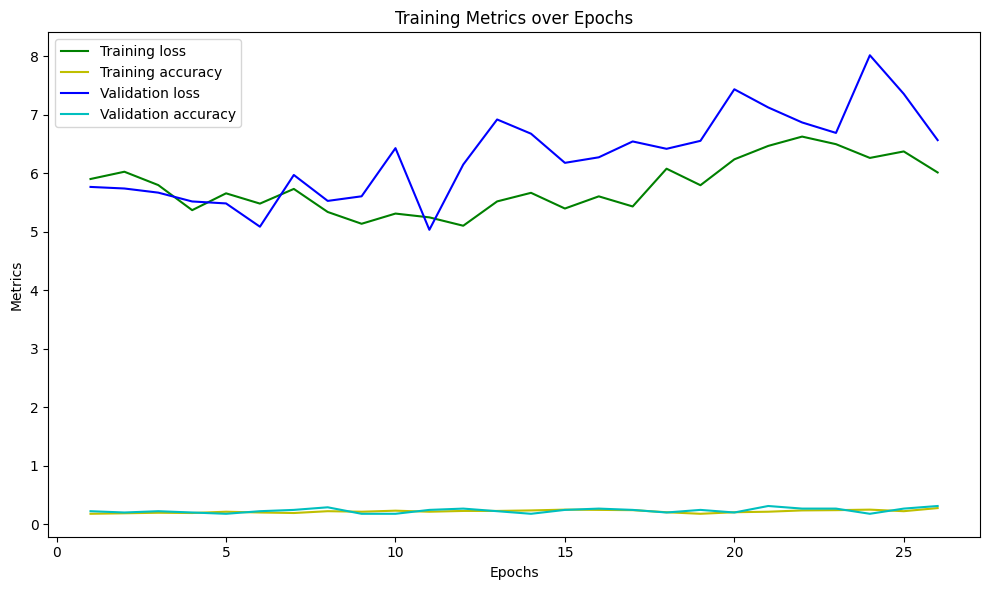

In [21]:
# Adjust the values to train
num_classes = num_classes
epochs = 50
learning_rate = 0.001
threshold = 0.5
early_stopping_patience = 15

cnn = CNN(num_classes, epochs, learning_rate, threshold, early_stopping_patience)
cnn.train(x_train, y_train, x_val, y_val)

In [22]:
base_filename = 'test22_model_final'
file_extension = 'h5'
unique_filename = Limiting.get_unique_filename(base_filename, file_extension)

# Save the model
cnn.save_model(unique_filename)

In [11]:
# !gdown "17OGLfYeCTdvo2wLnhWron0a6pnAmI3ph"
# !unzip data_shoe_sandal_boot.zip

Succesfully load model test22_model_final_0.h5
int_to_label:  {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}
Number of loaded images: 10


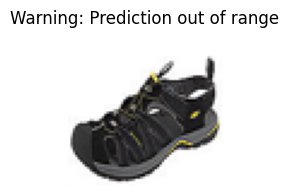

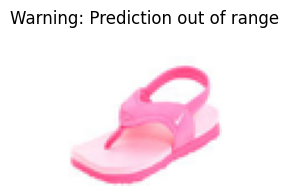

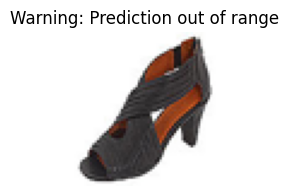

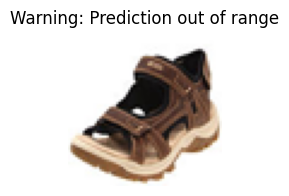

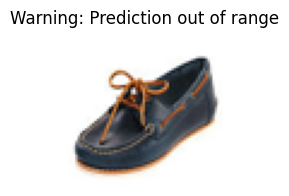

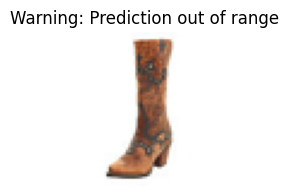

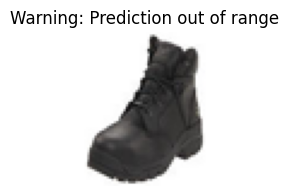

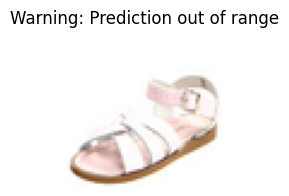

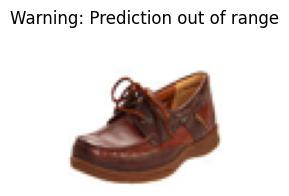

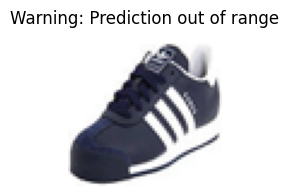

In [24]:
def load_random_images(folder_path, min_images=5, max_images=10, target_size=(64, 64)):
    # Check if the folder exists
    if not os.path.isdir(folder_path):
        print(f"Folder {folder_path} does not exist.")
        return []

    all_files = os.listdir(folder_path)
    image_files = [file for file in all_files if file.lower().endswith('.jpg')]
    
    # Check if there are any image files in the folder
    if not image_files:
        print(f"No .jpg image files found in folder {folder_path}.")
        return []

    num_images_to_select = min(max_images, len(image_files))  # Ensure we don't try to select more images than available
    selected_images = random.sample(image_files, num_images_to_select)
    images = []
    for image in selected_images:
        try:
            with Image.open(os.path.join(folder_path, image)) as img:
                img = img.convert('RGB')
                img = img.resize(target_size)
                img_data = list(img.getdata())
                img_3d = [[[img_data[w + h * target_size[0]][c] for c in range(3)] for w in range(target_size[0])] for h in range(target_size[1])]
                images.append(img_3d)
        except Exception as e:
            print(f"Error loading image {image}: {e}")

    # Check if any images were loaded
    if not images:
        print("No images were loaded.")
        return []

    return images


def print_predictions(predictions, images, int_to_label):
    num_images = len(images)
    print(f"Number of loaded images: {num_images}")

    for i, pred in enumerate(predictions):
        plt.figure(figsize=(2, 2))  # Adjust the size as needed
        image_data = images[i]
        plt.imshow(image_data)
        plt.axis('off')  # Hide the axis for a cleaner look
        
        # Check if the predicted class is within the expected range
        if isinstance(pred, list):
            predicted_class = pred.index(max(pred))
        else:
            predicted_class = pred

        if predicted_class in int_to_label:
            title = f"Predicted: {int_to_label[predicted_class]}"
        else:
            title = "Warning: Prediction out of range"
        
        plt.title(title)
        plt.show()

if __name__ == "__main__":
    # Load the model
    file_name = 'test22_model_final_0.h5'
    if os.path.isfile(file_name):
        cnn_loaded = CNN(num_classes=num_classes)
        cnn_loaded.load_model(file_name)
        
        print(f"Succesfully load model {file_name}")
    
        # Load random images from a folder
        folder_path = 'data_shoe_sandal_boot'  # Replace with the path to your folder
        random_images = load_random_images(folder_path)

        # Check if any images were loaded
        if not random_images:
            print("No images were loaded.")
            sys.exit()
        

        # Predict new images
        predictions = cnn_loaded.predict(random_images)

        # Check if any predictions were made
        if not predictions:
            print("No predictions were made.")
            sys.exit()

        # print("Predictions: ", predictions)
        print("int_to_label: ", dataset.int_to_label)

        # Print predictions
        print_predictions(predictions, random_images, dataset.int_to_label)
    else:
        print(f"The file {file_name} does not exist in the current directory.")